In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

np.random.seed(42)

# Generate 1000 samples
n_samples = 2000

# Generate features
stores = ['CityMart', 'Greenfield Grocers', 'SuperSaver Outlet', 'HighStreet Bazaar', 'Neighborhood Market']

data = {
    'item_code': [f'P{i:04d}' for i in range(1, n_samples + 1)],
    'store_name': np.random.choice(stores, n_samples),
    'mass': np.round(np.random.uniform(0.1, 10.0, n_samples), 2),
    'dimension_length': np.round(np.random.uniform(5, 100, n_samples), 2),
    'dimension_width': np.round(np.random.uniform(5, 100, n_samples), 2),
    'dimension_height': np.round(np.random.uniform(5, 100, n_samples), 2),
    'customer_score': np.random.randint(1, 6, n_samples),
    'total_reviews': np.random.randint(0, 1000, n_samples),
    'days_since_last_purchase': np.random.randint(0, 365, n_samples),
}

# Create DataFrame
df = pd.DataFrame(data)

# Add some derived features
df['package_volume'] = df['dimension_length'] * df['dimension_width'] * df['dimension_height']
df['stock_age'] = np.random.randint(1, 1000, n_samples)

# Generate price
price = (
    15 +
    0.5 * df['mass'] +
    np.random.normal(0, 5, n_samples)  # Add some noise
)
df['unit_cost'] = np.round(np.maximum(price, 1), 2)  # Ensure minimum price of 1

def sales_function(row, store_effect):
    base_sales = (
        150 +
        2 * row['mass'] +
        0.00007 * row['package_volume'] +
        10 * row['customer_score'] +
        0.05 * row['total_reviews'] +
        -0.05 * row['days_since_last_purchase'] +
        -2 * row['unit_cost']
    )
    return np.round(np.maximum(base_sales * store_effect + np.random.normal(0, 20), 0)).astype(int)

# Store-specific effects for A-D
store_sales_effects = {
    'CityMart': 1.2,
    'Greenfield Grocers': 0.7,
    'SuperSaver Outlet': 1.1,
    'HighStreet Bazaar': 1.4,
    'Neighborhood Market': 1  # Placeholder effect for Store E (will be replaced with regression prediction)
}

# Apply the sales function for Stores A-D
df['quantity_sold'] = df.apply(lambda row: sales_function(row, store_sales_effects[row['store_name']]), axis=1)

# Add datetime column
start_date = datetime(2023, 1, 1)
df['last_modified'] = [start_date + timedelta(days=x) for x in range(n_samples)]

# Split data for Stores A-D and Store E
df_ad = df[df['store_name'].isin(['CityMart', 'Greenfield Grocers', 'SuperSaver Outlet', 'HighStreet Bazaar'])]
df_e = df[df['store_name'] == 'Neighborhood Market']

# Features to use in regression (excluding 'product_id' and 'last_updated')
features = ['mass', 'dimension_length', 'dimension_width', 'dimension_height', 'package_volume', 'customer_score', 'total_reviews', 'days_since_last_purchase', 'unit_cost']

# Train a linear regression model on Stores A-D
X_train = df_ad[features]
y_train = df_ad['quantity_sold']

model = LinearRegression()
model.fit(X_train, y_train)

# Predict 'number_sold' for Store E using the trained model
X_test = df_e[features]
df.loc[df['store_name'] == 'Neighborhood Market', 'quantity_sold'] = np.round(np.maximum(model.predict(X_test).astype(int) + np.random.normal(0, 6), 0)).astype(int)

# Display the first few rows and data info
print(df.head())
print(df.info())

# Save the complete dataset
df.to_csv('complete_store_dataset2.csv', index=False)


  item_code           store_name  mass  dimension_length  dimension_width  \
0     P0001    HighStreet Bazaar  6.11             75.46            91.62   
1     P0002  Neighborhood Market  5.51             51.79            46.72   
2     P0003    SuperSaver Outlet  2.40             50.90             8.80   
3     P0004  Neighborhood Market  3.97             84.63            39.42   
4     P0005  Neighborhood Market  5.99             39.33            83.51   

   dimension_height  customer_score  total_reviews  days_since_last_purchase  \
0             92.08               2            972                        78   
1             72.02               3            260                       344   
2             68.82               2            285                       337   
3             42.46               5            512                       189   
4              5.12               3             85                       183   

   package_volume  stock_age  unit_cost  quantity_sold l

In [2]:
df.columns

Index(['item_code', 'store_name', 'mass', 'dimension_length',
       'dimension_width', 'dimension_height', 'customer_score',
       'total_reviews', 'days_since_last_purchase', 'package_volume',
       'stock_age', 'unit_cost', 'quantity_sold', 'last_modified'],
      dtype='object')


Correlation matrix:


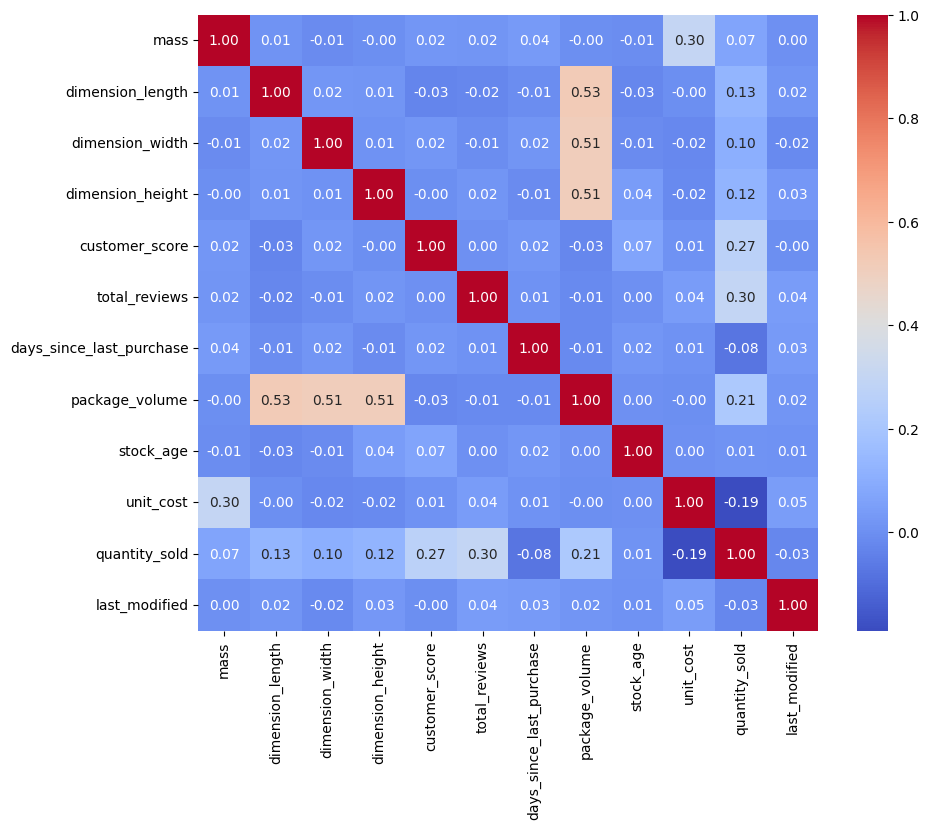

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# Correlation matrix
print("\nCorrelation matrix:")
corr_matrix = df.iloc[:,2:].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
from sklearn.metrics import mean_absolute_error

In [6]:
lr = LinearRegression()

In [7]:

dfe = df[df['store_name'] == 'Neighborhood Market']

for st in ['CityMart', 'Greenfield Grocers', 'SuperSaver Outlet', 'HighStreet Bazaar']:
    print()
    for st2 in ['CityMart', 'Greenfield Grocers', 'SuperSaver Outlet', 'HighStreet Bazaar']:
        if st == st2:
            continue
        df1 = df[df['store_name'] == f'{st}']
        df2 = df[df['store_name'] == f'{st2}']
        df_train = pd.concat([df1, df2])
        lr.fit(df_train.iloc[:, 2:-2], df_train.iloc[:, -2])
        pred = lr.predict(df_train.iloc[:, 2:-2])
        print(f"train on {st} x {st2}: {mean_absolute_error(pred, df_train.iloc[:, -2] )}")
        pred = lr.predict(dfe.iloc[:, 2:-2])
        print(f"test on E: {mean_absolute_error(pred, dfe.iloc[:, -2] )}")


train = df[df['store_name'] != 'Neighborhood Market']
lr.fit(train.iloc[:, 2:-2], train.iloc[:, -2])

print()

pred = lr.predict(train.iloc[:, 2:-2])
print(f"train all store_name: {mean_absolute_error(pred, train.iloc[:, -2] )}")

pred = lr.predict(dfe.iloc[:, 2:-2])
print(f"final test on E: {mean_absolute_error(pred, dfe.iloc[:, -2] )}")


train on CityMart x Greenfield Grocers: 43.37774102702816
test on E: 28.929363440664208
train on CityMart x SuperSaver Outlet: 16.256685361171314
test on E: 5.317018701104124
train on CityMart x HighStreet Bazaar: 21.109282213058073
test on E: 30.34005107642623

train on Greenfield Grocers x CityMart: 43.37774102702815
test on E: 28.929363440664197
train on Greenfield Grocers x SuperSaver Outlet: 35.74106748745561
test on E: 39.18564077730082
train on Greenfield Grocers x HighStreet Bazaar: 61.27348116763629
test on E: 12.503666592216769

train on SuperSaver Outlet x CityMart: 16.25668536117131
test on E: 5.317018701104132
train on SuperSaver Outlet x Greenfield Grocers: 35.74106748745561
test on E: 39.18564077730074
train on SuperSaver Outlet x HighStreet Bazaar: 27.697781221493834
test on E: 23.3655342164145

train on HighStreet Bazaar x CityMart: 21.10928221305805
test on E: 30.340051076426175
train on HighStreet Bazaar x Greenfield Grocers: 61.27348116763629
test on E: 12.50366659

In [8]:
import json

In [9]:
# Create a dictionary with product_id as key and volume as value
product_data = df.set_index('item_code')['unit_cost'].to_dict()
scrapable_data = df[['item_code', 'customer_score', 'total_reviews']].to_dict('records')
# Create the JavaScript code
js_code = f"""
const package_volume = {json.dumps(product_data, indent=2)};

const scrapableData = {json.dumps(scrapable_data, indent=2)};
"""

# Write the JavaScript code to a file
with open('api-mock-data.js', 'w') as js_file:
    js_file.write(js_code)

print("JavaScript file 'api-mock-data.js' has been generated.")

JavaScript file 'api-mock-data.js' has been generated.


In [10]:
df = df[['item_code',
'store_name',
'mass',
'dimension_length',
'dimension_width',
'dimension_height',
'days_since_last_purchase',
'package_volume',
'stock_age',
'quantity_sold',
'last_modified']]

In [11]:
df

,item_code,store_name,mass,dimension_length,dimension_width,dimension_height,days_since_last_purchase,package_volume,stock_age,quantity_sold,last_modified
0,P0001,HighStreet Bazaar,6.11,75.46,91.62,92.08,78,636608.450016,237,346,2023-01-01
1,P0002,Neighborhood Market,5.51,51.79,46.72,72.02,344,174261.666176,287,164,2023-01-02
2,P0003,SuperSaver Outlet,2.40,50.90,8.80,68.82,337,30825.854400,277,198,2023-01-03
3,P0004,Neighborhood Market,3.97,84.63,39.42,42.46,189,141651.425916,387,248,2023-01-04
4,P0005,Neighborhood Market,5.99,39.33,83.51,5.12,183,16816.375296,382,163,2023-01-05
...,...,...,...,...,...,...,...,...,...,...,...
1995,P1996,CityMart,9.90,66.40,75.90,9.88,101,49792.828800,501,232,2028-06-18
1996,P1997,Neighborhood Market,8.91,66.50,5.79,41.11,336,15828.788850,177,193,2028-06-19
1997,P1998,CityMart,3.78,17.19,21.02,37.04,82,13383.803952,800,192,2028-06-20
1998,P1999,Neighborhood Market,2.03,66.77,60.18,73.20,190,294133.601520,806,217,2028-06-21


In [12]:
# Split the data by store
stores = ['CityMart', 'Greenfield Grocers', 'SuperSaver Outlet', 'HighStreet Bazaar', 'Neighborhood Market']
store_dfs = {store: df[df['store_name'] == store] for store in stores}

In [13]:
def add_null(df, n = 3, columns = ['mass', 'dimension_length', 'dimension_width', 'days_since_last_purchase', 'stock_age', 'package_volume']):
    # Randomly select one column
    selected_column = np.random.choice(columns)
    
    # Randomly select 'n' indices to set to NaN
    indices = np.random.choice(df.index, size=n, replace=False)
    
    # Set the selected indices in the chosen column to NaN
    df.loc[indices, selected_column] = np.nan

    return df

In [14]:
# 'StoreA'
store = 'CityMart'

store_dfs[store] = add_null(store_dfs[store])

store_dfs[store].to_csv(f'{store}_data.csv', index=False)


In [15]:
# 'StoreB'
store = 'Greenfield Grocers'

store_dfs[store] = add_null(store_dfs[store])
store_dfs[store].columns = [col.upper() for col in store_dfs[store].columns]
store_dfs[store]['1'] = ''
store_dfs[store][''] = ''
# Write an empty line and then the data to CSV
with open(f'{store}_data.csv', 'w', newline='') as f:
    f.write(f'{"|"*(len(store_dfs[store].columns) -1)}\n')
    f.write(f'{"|"*(len(store_dfs[store].columns) -1)}\n')
    f.write(f'{"|"*(len(store_dfs[store].columns) -1)}\n')
    store_dfs[store].to_csv(f, index=False, sep='|')


/tmp/ipykernel_56859/2937629763.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_dfs[store]['1'] = ''
/tmp/ipykernel_56859/2937629763.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_dfs[store][''] = ''


In [16]:
# 'StoreC'
store = 'SuperSaver Outlet'

store_dfs[store] = add_null(store_dfs[store])

# Define the columns for each sheet
first_sheet_columns = ['item_code', 'quantity_sold']
second_sheet_columns = ['item_code',
'store_name',
'mass',
'dimension_length',
'dimension_width',
'dimension_height',
'days_since_last_purchase',
'package_volume',
'stock_age']

# Split the DataFrame
first_sheet_df = store_dfs[store][first_sheet_columns]
second_sheet_df = store_dfs[store][second_sheet_columns]
second_sheet_df.columns = [['item code',
'store name',
'mass',
'dimension length',
'dimension width',
'dimension height',
'days_since last_purchase',
'package volume',
'stock age']]
# Write to Excel in two sheets
with pd.ExcelWriter(f'{store}_data.xlsx', engine='openpyxl') as writer:
    first_sheet_df.to_excel(writer, sheet_name='Quantity', index=False)
    second_sheet_df.to_excel(writer, sheet_name='Info', index=False)

print(f"{store}_data.xlsx has been created with two sheets.")


SuperSaver Outlet_data.xlsx has been created with two sheets.


In [17]:
# 'StoreD'
store = 'HighStreet Bazaar'

store_dfs[store] = add_null(store_dfs[store])

store_dfs[store].to_json(f'{store}_data.json', orient='records')

In [18]:
# 'StoreE'
store = 'Neighborhood Market'

y = store_dfs[store][['item_code', 'quantity_sold']]
x = store_dfs[store].drop('quantity_sold', axis=1)

x.to_csv(f'{store}_data.csv', index=False)

y.to_csv(f'module4_test_test_target.csv', index=False)